In [68]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [9]:
cointegrations_df = pd.read_csv('cointegration_results.csv').dropna()
cointegrations_df = cointegrations_df[cointegrations_df['pvalue'] < 0.01].head(100)

In [ ]:
def filter_plausible_pairs_with_sector(df_pairs, col_name="pair"):
    """
    Filter a DataFrame of ticker pairs to only include pairs 
    where both tickers are in the same sector, and attach the shared sector.
    
    Parameters:
    -----------
    df_pairs : pd.DataFrame
        DataFrame with a column of ticker pairs in format "TICKER1_TICKER2"
    col_name : str
        Name of the column containing the ticker pairs
        
    Returns:
    --------
    pd.DataFrame
        Filtered DataFrame with only plausibly related pairs and a 'sector' column
    """

    # Extract tickers from the pair string
    tickers_set = set()
    for pair in df_pairs[col_name]:
        t1, t2 = pair.split("_", 1)
        tickers_set.update([t1, t2])
    tickers_list = list(tickers_set)

    # Lookup sectors using yfinance
    sectors_dict = {}
    for t in tickers_list:
        try:
            info = yf.Ticker(t).info
            sectors_dict[t] = info.get("sector")
        except:
            sectors_dict[t] = None

    # Filter pairs and attach sector
    plausible_pairs = []
    sectors = []
    for pair in df_pairs[col_name]:
        t1, t2 = pair.split("_", 1)
        sector1 = sectors_dict.get(t1)
        sector2 = sectors_dict.get(t2)

        if sector1 and sector2 and sector1 == sector2:
            plausible_pairs.append(pair)
            sectors.append(sector1)

    # Build output DataFrame
    filtered_df = pd.DataFrame({
        col_name: plausible_pairs,
        "sector": sectors
    }).reset_index(drop=True)

    return filtered_df

# -----------------------------
# Example usage:
# -----------------------------
filtered_pairs_df = filter_plausible_pairs_with_sector(cointegrations_df)
print(filtered_pairs_df)


        pair              sector
0     A_CLDX          Healthcare
1      A_DGX          Healthcare
2      AA_IE     Basic Materials
3     AA_VGZ     Basic Materials
4  AACI_BCSF  Financial Services
5  AACI_DSAQ  Financial Services
6  AACI_EHTH  Financial Services
7  AACI_GLRE  Financial Services


In [26]:
prices_df = pd.read_pickle('/Users/LoganDeboo/Desktop/git_projects/portfolio_construction_research/testing.pkl')
prices_df = prices_df[['Ticker', 'Date', 'publish_date_price']]
prices_df = prices_df.pivot(index="Date", columns="Ticker", values="publish_date_price")
prices_df = prices_df.sort_index()

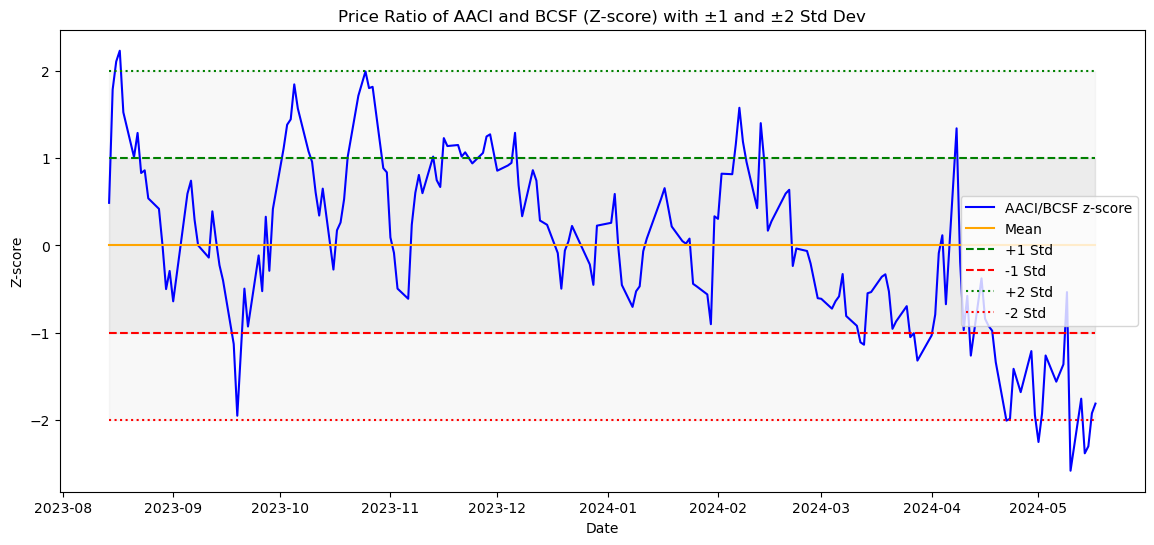

In [ ]:
# for pair in filtered_pairs_df['pair']:
ticker_one, ticker_two = "AACI", "BCSF"

asset_pair = prices_df[[ticker_one, ticker_two]].dropna()

asset_pair['ratio'] = asset_pair[ticker_one] / asset_pair[ticker_two]
asset_pair['log_ratio'] = np.log(asset_pair['ratio'])
asset_pair['log_ratio_zscore'] = (asset_pair['log_ratio'] - asset_pair['log_ratio'].mean()) / asset_pair['log_ratio'].std() 

ratio = asset_pair['log_ratio_zscore']

plt.figure(figsize=(14,6))
plt.plot(asset_pair.index, ratio, label=f'{ticker_one}/{ticker_two} z-score', color='blue')

# Mean line
plt.plot(asset_pair.index, [0]*len(ratio), label='Mean', color='orange')

# ±1 std
plt.plot(asset_pair.index, [1]*len(ratio), label='+1 Std', color='green', linestyle='--')
plt.plot(asset_pair.index, [-1]*len(ratio), label='-1 Std', color='red', linestyle='--')
plt.fill_between(asset_pair.index, -1, 1, color='grey', alpha=0.1)

# ±2 std
plt.plot(asset_pair.index, [2]*len(ratio), label='+2 Std', color='green', linestyle=':')
plt.plot(asset_pair.index, [-2]*len(ratio), label='-2 Std', color='red', linestyle=':')
plt.fill_between(asset_pair.index, -2, 2, color='grey', alpha=0.05)

plt.title(f'Price Ratio of {ticker_one} and {ticker_two} (Z-score) with ±1 and ±2 Std Dev')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.show()


=== Pairs Trading Backtest Results ===
Pair: AACI/BCSF
Initial Capital: $100
Final Equity: $105
Total Return: 5.26%
Annualized Return: 7.15%
Volatility: 3.60%
Sharpe Ratio: 1.99
Maximum Drawdown: 1.45%
Total Trades: 7
Win Rate: 100.0%


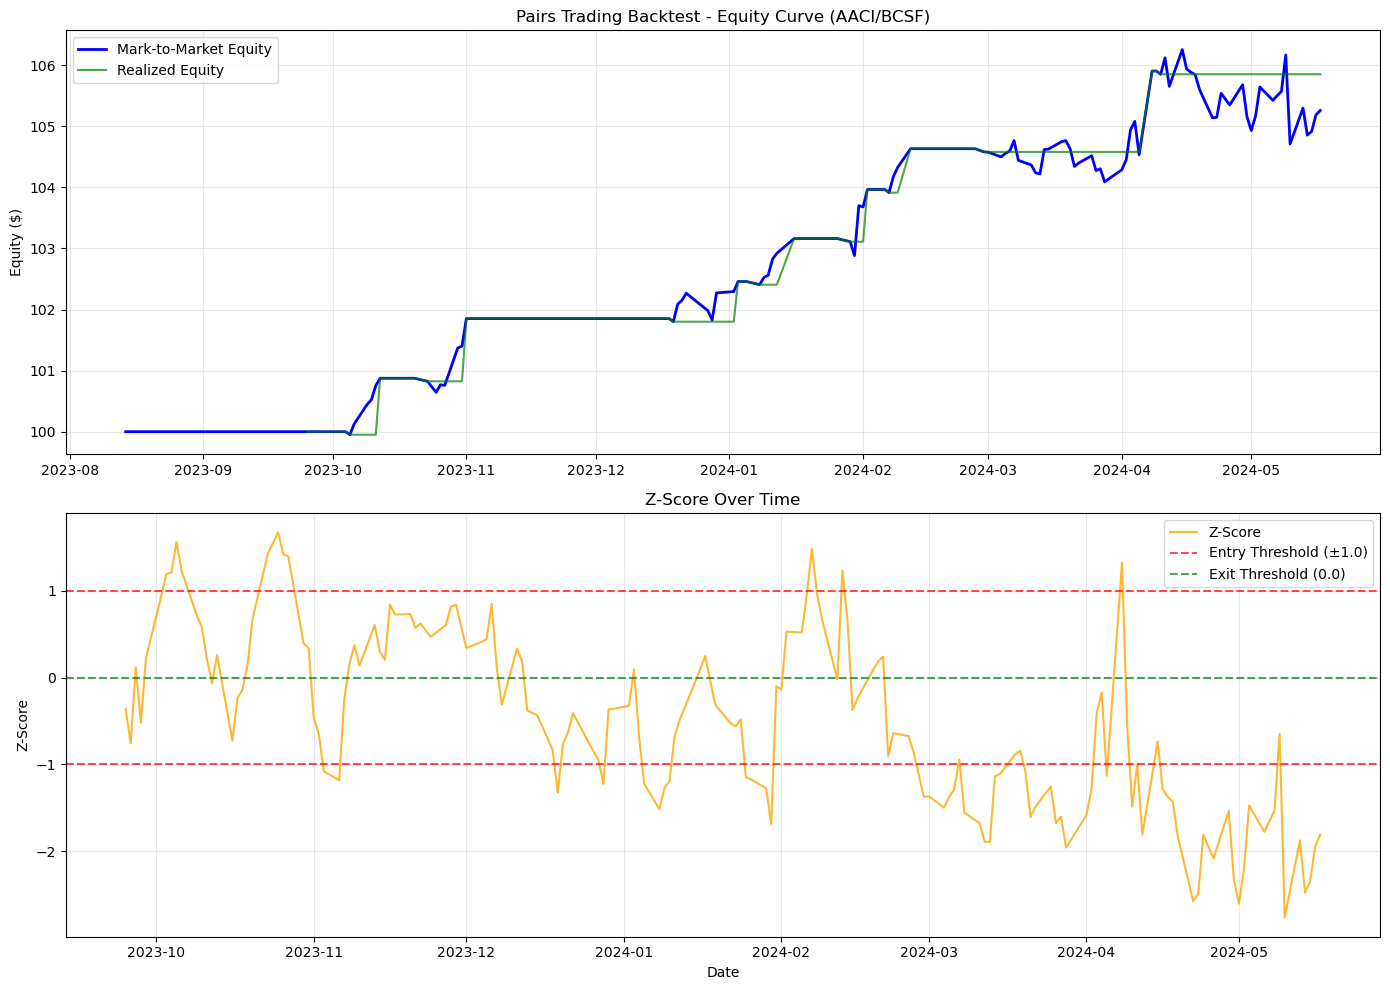

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
entry_threshold = 1.0  # z-score to enter
exit_threshold = 0.0   # z-score to exit
initial_cash = 100000
lookback_window = 252  # days for rolling statistics
min_periods = 30      # minimum periods before trading
commission = 0.001    # 0.1% commission per trade
position_size = 0.5   # fraction of equity to risk per trade

def calculate_rolling_zscore(log_ratio, window=252, min_periods=30):
    """Calculate z-score using rolling statistics to avoid look-ahead bias"""
    rolling_mean = log_ratio.rolling(window=window, min_periods=min_periods).mean()
    rolling_std = log_ratio.rolling(window=window, min_periods=min_periods).std()
    zscore = (log_ratio - rolling_mean) / rolling_std
    return zscore, rolling_mean, rolling_std

def pairs_trading_backtest(
        asset_pair,
        ticker_one,
        ticker_two, 
        entry_threshold=1.25,
        exit_threshold=0.0, 
        initial_cash=100,
        position_size=0.5,
        lookback_window=252,
        commission=0.001
) -> pd.DataFrame:
    """
    Improved pairs trading backtest with proper risk management
    """
    # Create a copy to avoid modifying original data
    df = asset_pair.copy()
    
    # Calculate log ratio
    df['log_ratio'] = np.log(df[ticker_one]) - np.log(df[ticker_two])
    
    # Calculate rolling z-score to avoid look-ahead bias
    df['zscore'], df['rolling_mean'], df['rolling_std'] = calculate_rolling_zscore(
        df['log_ratio'], window=lookback_window
    )
    
    # Initialize tracking variables
    results = []
    equity = initial_cash
    position_one = 0  # shares of ticker_one
    position_two = 0  # shares of ticker_two
    entry_price_one = 0
    entry_price_two = 0
    trade_count = 0
    winning_trades = 0
    
    for date, row in df.iterrows():
        z = row['zscore']
        price1 = row[ticker_one]
        price2 = row[ticker_two]
        
        # Skip if we don't have valid z-score yet
        if pd.isna(z) or pd.isna(row['rolling_std']) or row['rolling_std'] == 0:
            results.append({
                'date': date,
                'equity': equity,
                'position_one': 0,
                'position_two': 0,
                'zscore': z,
                'unrealized_pnl': 0
            })
            continue
        
        # Calculate current P&L if in position
        unrealized_pnl = 0
        if position_one != 0 and position_two != 0:
            pnl_one = position_one * (price1 - entry_price_one)
            pnl_two = position_two * (price2 - entry_price_two)
            unrealized_pnl = pnl_one + pnl_two
        
        # Entry logic - only enter if not already in position
        if position_one == 0 and position_two == 0:
            trade_value = equity * position_size
            
            if z > entry_threshold:
                # Z-score high: short ticker_one (overvalued), long ticker_two (undervalued)
                shares_one = -trade_value / (2 * price1)  # negative = short
                shares_two = trade_value / (2 * price2)   # positive = long
                
                position_one = shares_one
                position_two = shares_two
                entry_price_one = price1
                entry_price_two = price2
                entry_date = date
                
                # Apply transaction costs
                transaction_cost = abs(shares_one * price1 * commission) + abs(shares_two * price2 * commission)
                equity -= transaction_cost
                
            elif z < -entry_threshold:
                # Z-score low: long ticker_one (undervalued), short ticker_two (overvalued)
                shares_one = trade_value / (2 * price1)   # positive = long
                shares_two = -trade_value / (2 * price2)  # negative = short
                
                position_one = shares_one
                position_two = shares_two
                entry_price_one = price1
                entry_price_two = price2
                entry_date = date
                
                # Apply transaction costs
                transaction_cost = abs(shares_one * price1 * commission) + abs(shares_two * price2 * commission)
                equity -= transaction_cost
        
        # Exit logic
        elif position_one != 0 and position_two != 0:
            should_exit = False
            
            # Exit when z-score reverts to exit threshold
            if position_one > 0:  # Long ticker_one position
                should_exit = z >= exit_threshold
            else:  # Short ticker_one position
                should_exit = z <= exit_threshold
            
            if should_exit:
                # Calculate final P&L
                pnl_one = position_one * (price1 - entry_price_one)
                pnl_two = position_two * (price2 - entry_price_two)
                total_pnl = pnl_one + pnl_two
                
                # Apply transaction costs for exit
                transaction_cost = abs(position_one * price1 * commission) + abs(position_two * price2 * commission)
                
                # Update equity
                equity += total_pnl - transaction_cost
                
                # Track trade statistics
                trade_count += 1
                if total_pnl > 0:
                    winning_trades += 1
                
                # Reset positions
                position_one = 0
                position_two = 0
                entry_price_one = 0
                entry_price_two = 0
                entry_date = None
                unrealized_pnl = 0
        
        # Calculate mark-to-market equity
        mtm_equity = equity + unrealized_pnl
        
        # Store results
        results.append({
            'date': date,
            'equity': mtm_equity,
            'realized_equity': equity,
            'position_one': position_one,
            'position_two': position_two,
            'zscore': z,
            'unrealized_pnl': unrealized_pnl,
            'price_one': price1,
            'price_two': price2
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('date', inplace=True)
    
    # Calculate performance metrics
    returns = results_df['equity'].pct_change().dropna()
    total_return = (results_df['equity'].iloc[-1] / initial_cash - 1) * 100
    annual_return = ((results_df['equity'].iloc[-1] / initial_cash) ** (252 / len(results_df)) - 1) * 100
    volatility = returns.std() * np.sqrt(252) * 100
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    max_drawdown = ((results_df['equity'].cummax() - results_df['equity']) / results_df['equity'].cummax()).max() * 100
    win_rate = (winning_trades / trade_count * 100) if trade_count > 0 else 0
    
    print(f"=== Pairs Trading Backtest Results ===")
    print(f"Pair: {ticker_one}/{ticker_two}")
    print(f"Initial Capital: ${initial_cash:,.0f}")
    print(f"Final Equity: ${results_df['equity'].iloc[-1]:,.0f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annual_return:.2f}%")
    print(f"Volatility: {volatility:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Total Trades: {trade_count}")
    print(f"Win Rate: {win_rate:.1f}%")
    
    return results_df

# Plotting function
def plot_backtest_results(results_df, ticker_one, ticker_two):
    """Plot backtest results with equity curve and z-score"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot equity curve
    ax1.plot(results_df.index, results_df['equity'], label='Mark-to-Market Equity', color='blue', linewidth=2)
    ax1.plot(results_df.index, results_df['realized_equity'], label='Realized Equity', color='green', alpha=0.7)
    ax1.set_title(f'Pairs Trading Backtest - Equity Curve ({ticker_one}/{ticker_two})')
    ax1.set_ylabel('Equity ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot z-score with entry/exit thresholds
    ax2.plot(results_df.index, results_df['zscore'], label='Z-Score', color='orange', alpha=0.8)
    ax2.axhline(y=entry_threshold, color='red', linestyle='--', alpha=0.7, label=f'Entry Threshold (±{entry_threshold})')
    ax2.axhline(y=-entry_threshold, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(y=exit_threshold, color='green', linestyle='--', alpha=0.7, label=f'Exit Threshold ({exit_threshold})')
    ax2.set_title('Z-Score Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Z-Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# To run the backtest, uncomment and modify the following lines:
# results = pairs_trading_backtest(asset_pair, 'TICKER_ONE', 'TICKER_TWO')
# plot_backtest_results(results, 'TICKER_ONE', 'TICKER_TWO')

ticker_one = 'AACI'
ticker_two = 'BCSF'
results = pairs_trading_backtest(asset_pair, ticker_one, ticker_two)
plot_backtest_results(results, ticker_one, ticker_two)